In [1]:
# import glob
# import os
# import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def common_preprocess(df, scale):
    '''Preprocessing that is common to all statistical tables
    Parameters:
        - df: dataframe of tables from FBRef
        - scale: type of table - either team data or individual data
    Returns:
        - games: games played by team'''

    df.drop(columns=['Unnamed: 0'], inplace=True)
    # Function to divide relevant columns by games played
    games = df['90s']
    
    if scale == 'team': 
        df.drop(columns=['# Pl'], inplace=True)

    if scale == 'individual':
        df['Pos']= df['Pos'].str.split(',',expand=True)[0] # If multiple positions listed, take first (not scientific, but mostly for validation anyway)
        df['Nation'] = df['Nation'].str.split(' ', expand=True)[1] #Gives only 3-letter country abbreviation
        df.drop(columns=['Rk' , 'Age', 'Matches'], inplace=True)
    
    return games


In [3]:
# Function to normalize to per-90 stats (i.e. per full game equivalent)
# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[0]}.csv")
def shooting_preprocess(df, scale):
    '''Preprocess 'Shooting' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns
        - df: processed dataframe'''

    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    # Drop dead-ball opportunities
    df.drop(columns=['FK', 'PK', 'PKatt', 'xG', 'G-xG'], inplace=True) 

    # Drop columns that are already per 90
    df.drop(columns=['Sh', 'SoT'], inplace=True) 

    # executing the function
    df[["Gls", "npxG", "np:G-xG"]] = df[["Gls", "npxG", "np:G-xG"]].apply(lambda x: x/games)

    # Rename to reflect 'per-90' status
    df.rename(columns={"Gls": "Gls/90", "npxG": "npxG/90", "Dist": "AvgShotDist"}, inplace=True)

    # Percentages between 0-1
    df[["SoT%"]] = df[["SoT%"]].apply(lambda x: x/100)
    
    # 'Dist' stat gives N/A if player hasn't shot; make it some large number (for clustering purposes)
    df['AvgShotDist'].fillna(37, inplace=True)

    return df

In [4]:

# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[1]}.csv")
def passing_preprocess(df, scale):
    '''Preprocess 'Passing' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns
        - df: processed dataframe'''
    
    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    # executing the per-90 function on relevant stats.
    df[["Cmp", "Att", "TotDist", "PrgDist", "Cmp.1", "Att.1", "Cmp.2", "Att.2", "Cmp.3", "Att.3",
        "Ast", "xA", "A-xA", "KP", "1/3", "PPA", "CrsPA", "Prog" ]] = df[["Cmp", "Att", "TotDist", "PrgDist", "Cmp.1", 
        "Att.1", "Cmp.2", "Att.2", "Cmp.3", "Att.3",
        "Ast", "xA", "A-xA", "KP", "1/3", "PPA", "CrsPA", "Prog" ]].apply(lambda x: x/games)
    
    # Reca

    # Normalize distances so they are 'distances per pass'
    df["TotDist"]= df["TotDist"]/df["Cmp"]
    df.rename(columns={"TotDist": "TotDist/pass"}, inplace=True)

    df["PrgDist"] = df["PrgDist"]/df["Cmp"]
    df.rename(columns={"PrgDist": "PrgDist/Pass"}, inplace=True)

    # Rename short/medium/long
    df.rename(columns = {"Att.1": "ShortAtt", "Cmp%.1": "Short%", "Att.2": "MedAtt", "Cmp%.2": "Med%","Att.3": "LongAtt", "Cmp%.3": "Long%"}, inplace=True)

    # Find proportion of total passes that are short ( <5 yds), medium (5-15 yds) or long (> 15 yds)
    df["PropShort"] = df["ShortAtt"]/df["Att"]
    
    df["PropMed"] = df["MedAtt"]/df["Att"]
    
    df["PropLong"]= df["LongAtt"]/df["Att"]


    # Make between 0-1
    df[["Short%", "Med%", "Long%"]] = df[["Short%", "Med%", "Long%"]].apply(lambda x: x/100)

    # As above, but with other passing stats
    df["PropAssistShots"] = df["KP"]/df["Cmp"]
    
    df["PropFinalThirdPasses"]= df["1/3"]/df["Cmp"]
    
    df["PropPassinPA"]= (df["PPA"] - df['CrsPA'])/df["Cmp"]
    
    df["PropCrossinPA"]= df["CrsPA"]/df["Cmp"]

    # Drop columns we won't need anymore
    df.drop(columns=['Cmp', 'Att', 'ShortAtt', 'MedAtt', 'LongAtt', 'Cmp%', 'Cmp.1', 'Cmp.2', 'Cmp.3', 'KP', '1/3', 'PPA', 'CrsPA','Prog'], inplace=True) 
    
    return df 

In [5]:
# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[2]}.csv")
# print(df.columns)

def passing_types_preprocess(df, scale):
    '''Preprocess 'Pass Type' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns
        - df: processed dataframe'''
    
    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    # Some stats here are redundant from the "Passing" stat, so we'll drop them
    # Also some we just don't care about: dead balls, "Other" passes (which is likely keeper throwing it)
    df.drop(columns = ['Att', 'Dead', 'CK', 'In', 'Out', 'Str', 'Other'], inplace=True)

    # Offsides could be interesting, as it suggests through/attacking balls, but it is only like 2% of passes, so let's drop
    # df.drop(columns = ['Off'], inplace=True)

    #...or not


    # executing the per-90 function on relevant stats
    df[["Live", "FK", "TB", "Press", "Sw", "Crs", "Ground", "Low", "High", "Left", "Right", "Head", "TI", 
        "Cmp", "Out.1", "Int", "Blocks" ]] =  df[["Live", "FK", "TB", "Press", "Sw", "Crs", "Ground", "Low", "High", 
        "Left", "Right", "Head", "TI", "Cmp", "Out.1", "Int", "Blocks" ]].apply(lambda x: x/games)
    
    # Normalize certain stats to be per pass
    # 'TB' (completed pass b/w back two defenders into open space) has a max of 0.63-per-90, so don't normalize
    live_passes = df['Live'][0]
    df[["Press", "Sw", "Crs", "Out.1", "Int", "Blocks"]] = df[[ "Press", "Sw", "Crs", "Out.1", "Int", "Blocks"]].apply(lambda x: x/live_passes)
    df.rename(columns ={"Press": "PropPassUnderPress", "Out.1": "PropPassOut", "Int": "PropPassInt", "Blocks": "PropPassBlocked"}, inplace=True)

    # For "Height", it includes dead-ball kicks (which we don't care about). We'll do a sill trick:
    # Assume 10% of Dead ball kicks are 'low', 20% 'ground' and 70% are 'high'. Then subtract those amounts from the height stats
    df["Ground"] = df["Ground"] - 0.1*df["FK"]
    df["Low"] = df["Low"] - 0.2*df["FK"]
    df["High"] = df["High"] - 0.7*df["FK"]

    # Then, find the proportion of each height...
    df["Ground"] = df["Ground"]/df["Live"]
    df["Low"] = df["Low"]/df["Live"]
    df["High"] = df["High"]/df["Live"]
    df.rename(columns={"Ground": "PropPassGround", "Low": "PropPassLow", "High": "PropPassHigh"}, inplace=True)

     #...and the proportion from each body part (no normalization from dead balls though)
    df["Left"] = df["Left"]/df["Live"]
    df["Right"] = df["Right"]/df["Live"]
    df["Head"] = df["Head"]/df["Live"]
    df.rename(columns={"Live": "TotPassAtt", "Left": "PropLeft", "Right": "PropRight", "Head": "PropHead"}, inplace=True)

    # Drop columns we won't need anymore
    df.drop(columns=[ 'TB', 'Cmp', 'FK', 'Off'], inplace=True) 
    
    return df 

In [6]:

# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[3]}.csv")
# print(df.columns)
def gca_preprocess(df, scale):
    '''Preprocess 'Goal and shot creation' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns
        - df: processed dataframe
        '''
    
    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    # SCA, GCA already per-90'ed
    df.drop(columns = ['SCA', 'GCA'], inplace=True)

    # Dead ball things to drop
    df.drop(columns = ['PassDead', 'Fld', 'PassDead.1', 'Fld.1'], inplace=True)


    # executing the per-90 function on relevant stats
    df[["PassLive", "Drib", "Sh", "Def", "PassLive.1", "Drib.1", "Sh.1", "Def.1"]] = df[["PassLive",
     "Drib", "Sh", "Def", "PassLive.1", "Drib.1", "Sh.1", "Def.1"]].apply(lambda x: x/games)
    df.rename(columns ={"PassLive": "SCPass/90", "Drib": "SCDrib/90",  "Sh": "SCSh/90", "Def": "SCDef/90",
     "PassLive.1": "GCPass/90", "Drib.1": "GCDrib/90",  "Sh.1": "GCSh/90", "Def.1": "GCDef/90"}, inplace=True)

    # Drop certain GC stats:low numbers, and seems irrelevant (adding here so it can potentially be commented out) 
    df.drop(columns=['GCSh/90', 'GCDef/90'], inplace=True) 
    
    # Drop columns we won't need anymore
    # df.drop(columns=['Att', 'Dead'], inplace=True) 
    
    return df 

In [7]:
# newer_df = goal_shot_creation_preprocess(df)
# newer_df

In [8]:

# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[4]}.csv")
# print(df.columns)
def possession_preprocess(df, scale):
    '''Preprocess 'Possession' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns
        - df: processed dataframe
        '''
    
    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    if scale == 'team': 
        # Make % between 0-1
        df[["Poss", "Rec%"]] = df[["Poss", "Rec%"]].apply(lambda x: x/100)
        df['OppPoss'] = 1 - df['Poss']

    # Make % between 0-1
    df[["Succ%", "Rec%"]] = df[["Succ%", "Rec%"]].apply(lambda x: x/100)
    df.rename(columns={"Succ%": "DribSucc%"}, inplace=True)
    
    
    # Stats to drop (either taken into account, irrelevant or too small to matter)
    df.drop(columns = ["Touches", "Live", "Megs" ], inplace=True)

    # executing the per-90 function on relevant stats
    df[['Succ', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Att',
       '#Pl', 'Carries', 'TotDist', 'PrgDist', 'Prog', '1/3',
       'CPA', 'Mis', 'Dis', 'Targ', 'Rec', 'Prog.1']] = df[['Succ', 'Def Pen', 'Def 3rd',
      'Mid 3rd', 'Att 3rd', 'Att Pen', 'Att', '#Pl', 'Carries', 'TotDist', 'PrgDist',
       'Prog', '1/3','CPA', 'Mis', 'Dis', 'Targ', 'Rec', 'Prog.1']].apply(lambda x: x/games)


    # Touches per area don't add up to total touches stat. Add them up, then normalize so it's
    # proportion of actions at each location; Also think "Pen" touches are taken from that third, 
    # so subtract "Pen" touches from that area.
    # (Dead ball touches is included in here? Have to assume it won't change proportion too much, I guess) 

    total_touches = df['Def 3rd'] + df['Mid 3rd'] + df['Att 3rd']
    df["Def 3rd"] = df["Def 3rd"] - df["Def Pen"] 
    df["Att 3rd"] = df["Att 3rd"] - df["Att Pen"]
    df[['Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen']] =  df[['Def Pen', 'Def 3rd', 
    'Mid 3rd', 'Att 3rd', 'Att Pen']].apply(lambda x: x/total_touches)
    df.rename(columns={'Def Pen': 'Prop Def Pen Touches', 'Def 3rd': 'Prop Def 3rd Touches', 'Mid 3rd': 'Prop Mid 3rd Touches', 
    'Att 3rd': 'Prop Att 3rd Touches', 'Att Pen': 'Prop Att Pen Touches'},inplace=True)
    df['TotalTouches'] = total_touches

    df['#Pl'] = df['#Pl']/df['Succ'] 
    df.rename(columns={'#Pl': '#Pl/Drib'},inplace=True)
    
    # Do some carries normalizing
    df['Prog'] = df['Prog']/df['Carries'] 
    df.rename(columns={'Prog': 'PropProg'},inplace=True)

    df['PrgDist'] = df['PrgDist']/df['TotDist'] 
    df.rename(columns={'PrgDist': 'PropPrgDist'},inplace=True)
    
    df['TotDist'] = df['TotDist']/df['Carries'] 
    df.rename(columns={'TotDist': 'TotDist/Carry'},inplace=True)

    df['1/3'] = df['1/3']/df['Carries'] 
    df.rename(columns={'1/3': 'CarriesinFinalThird'},inplace=True)

    df['Mis'] = df['Mis']/df['Carries'] 
    df.rename(columns={'Mis': 'Misplayed/Carry'},inplace=True)
    
    df['Dis'] = df['Dis']/df['Carries'] 
    df.rename(columns={'Dis': 'Displaced/Carry'},inplace=True)
    
    df['CPA'] = df['CPA']/df['Carries'] 
    df.rename(columns={'CPA': 'PropCPA'},inplace=True)

    # And some receiving normalizing
    df['Prog.1'] = df['Prog.1']/df['Rec'] 
    df.rename(columns={'Prog.1': 'ProgPassRec', 'Mid 3rd': 'Mid 3rd Touches', 'Att': 'AttDribbles'},inplace=True)
    # Drop columns we won't need anymore
    df.drop(columns=['Succ', 'Rec'], inplace=True) 
    

    return df 

In [9]:
# df2 = pd.read_csv(f"../data/raw/individual/{leagues[0]}-2021-2022-individual-{stats[4]}.csv")

In [10]:
# df2['Nation'].str.split(' ', expand=True)[1]

In [11]:
# poss_df = possession_preprocess(df2, 'individual')
# poss_df2 = possession_preprocess(df, 'team')
# poss_df

In [12]:
# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[5]}.csv")
# print(df.columns)
def defense_preprocess(df, scale):
    '''Preprocess 'Defensive actions' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns￼￼
        - df: processed dataframe
        '''

    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    
    # Stats to drop (either taken into account, or too small to matter)
    df.drop(columns = [], inplace=True)

    # executing the per-90 function on relevant stats
    df[["Tkl", "TklW", "Def 3rd", "Mid 3rd", "Att 3rd",  "Att", "Press", "Succ",  "Def 3rd.1", "Mid 3rd.1", 
    "Att 3rd.1", "Blocks", "Sh", "Pass", "Int", "Clr"]] = df[["Tkl", "TklW", "Def 3rd", "Mid 3rd", "Att 3rd", 
    "Att", "Press", "Succ", "Def 3rd.1", "Mid 3rd.1", "Att 3rd.1", "Blocks", "Sh", "Pass", "Int", "Clr"]].apply(lambda x: x/games)

    # Find proportion of actions at each location
    df['TklW'] = df['TklW']/df['Tkl']
    df['Def 3rd'] = df['Def 3rd']/df['Tkl']
    df['Mid 3rd'] = df['Mid 3rd']/df['Tkl']
    df['Att 3rd'] = df['Att 3rd']/df['Tkl']
    
    # Make between 0-1
    df[["Tkl%", "%"]] = df[["Tkl%", "%"]].apply(lambda x: x/100)
    
    df['Def 3rd.1'] = df['Def 3rd.1']/df["Press"]
    df['Mid 3rd.1'] = df['Mid 3rd.1']/df["Press"]
    df['Att 3rd.1'] = df['Att 3rd.1']/df["Press"]

    df["Sh"] = df["Sh"]/df["Blocks"]
    df["Pass"] = df["Pass"]/df["Blocks"]
    
    df.rename(columns ={"TklW": "Tkl%", "Def 3rd": "PropTkl Def 3rd", "Mid 3rd": "PropTkl Mid 3rd", "Att 3rd": "PropTkl Att 3rd",
     "Att": "DribTkl", "Tkl%": "DribTkl%", "%": "SuccPress%", "Def 3rd.1": "PropPress Def 3rd", "Mid 3rd.1": "PropPress Mid 3rd", 
     "Att 3rd.1": "PropPress Att 3rd", "Sh": "PropBlockSh", "Pass": "PropBlockPass"}, inplace=True)
    
    
    # Drop columns we won't need anymore
    df.drop(columns=['Tkl+Int', 'Tkl.1', 'Past', "Succ", "ShSv", 'Err'], inplace=True) 
    
    return df 

In [13]:
# df = pd.read_csv(f"../data/raw/individual/{leagues[0]}-2021-2022-individual-{stats[6]}.csv")
# print(df.columns)
def playingtime_preprocess(df, scale):
    '''Preprocess 'Playing time' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns￼￼
        - df: processed dataframe
        '''
    
    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)
    # executing the per-90 function on relevant stats
    df[["onG", "onGA", "onxG", "onxGA"]] = df[["onG", "onGA", "onxG", "onxGA"]].apply(lambda x: x/games)
    
    # Find g-xg diff
    df["onG-xG"] = df['onG'] - df['onxG']
    df["onGA-xGA"] = df['onGA'] - df['onxGA']
    df["G-xG+/-"] = df['+/-'] - df['xG+/-']

    # Stats to drop (either taken into account, or too small to matter)
    df.drop(columns = ['MP', 'Min', 'Mn/MP', 'Min%', 'Starts', 'Mn/Start', 'Compl',
    'Subs', 'Mn/Sub', 'unSub', 'PPM', '+/-', 'xG+/-'], inplace=True)

    # All stats are per-90 normalized, so remove that from label
    df.rename(columns={'+/-90': '+/-', 'xG+/-90': 'xG+/-'}, inplace=True)

    if scale == 'individual':
        df.drop(columns={'On-Off.1'}, inplace=True)

    return df 

In [14]:
# df.head()

In [15]:
# pt_df = playingtime_preprocess(df, 'individual')
# pt_df

In [16]:

# df = pd.read_csv(f"../data/raw/team/{leagues[0]}-2021-2022-team-{stats[7]}.csv")
# print(df.columns)
def misc_preprocess(df, scale):
    '''Preprocess 'Miscallaneous' stat from FBRef
    Parameters:
        - df: dataframe of Statsbomb statistical data taken from FBRef 
    Returns￼￼
        - df: processed dataframe
        '''
    
    # Processing that is common to all dataframes 
    games = common_preprocess(df, scale)

    # Stats to drop (either taken into account, or too small to matter)
    # OG could be interesting, but there are so few that it could skew results
    df.drop(columns = ['2CrdY', 'CrdR', 'Crs', 'Int', 'TklW', 'OG'], inplace=True)
    
    # executing the per-90 function on relevant stats
    df[["Fls", "Fld", "Off", "PKwon", "PKcon", "Recov", "Won", "Lost",
    ]] = df[["Fls", "Fld", "Off", "PKwon", "PKcon", "Recov", "Won", 
    "Lost"]].apply(lambda x: x/games)
    df.rename(columns={"Off": "TimesOffside"}, inplace=True) #Change stat name that comes up repeateedly 
    
    # Turn % into number between 0-1
    df[["Won%"]] = df[["Won%"]].apply(lambda x: x/100)
    df.rename(columns={"Won%": "DuelWin%"}, inplace=True)

    # Find total number of aerial duels
    df['AerialDuels'] = df['Won'] + df['Lost'] 
    

    # Stats to drop (either taken into account, or too small to matter)
    df.drop(columns = ['Won', 'Lost'], inplace=True)
    
    # df.drop(columns = ['Won', 'Lost', 'On-Off.1'], inplace=True)

    # All stats are per-90 normalized, so remove that from label
    df.rename(columns={'+/-90': '+/-', 'xG+/-90': 'xG+/-'}, inplace=True)

    return df 

In [17]:
scales = ['team', 'individual']
stats = ['shooting', 'passing', 'passing_types', 'gca', 'possession', 'defense', 'playingtime', 'misc']
leagues = ['La-Liga', 'Premier-League', 'Ligue-1', 'Bundesliga',  'Serie-A', 'Major-League-Soccer']

In [18]:
# Loop through above lists to get all data. Also will need to append dfs -> stats along axis 1, leagues along axis 0
scale_frames = []
for scale in scales:
    league_frames = []
    for league in leagues: 
        stat_frames = []
        for stat in stats:
            # Below, account for MLS being in one calendar year. Only using one year of data, so not generalizing
            if (league == 'Major-League-Soccer'):   
                df = pd.read_csv(f"../data/raw/{scale}/{league}-2022-{scale}-{stat}.csv")
            else:
                df = pd.read_csv(f"../data/raw/{scale}/{league}-2021-2022-{scale}-{stat}.csv")
            func = 'processed_df = '+stat+'_preprocess(df, scale)' # Allows us to call unique function for each stat
            exec(func)
            # Add league to the dataframe
            processed_df.insert(1, 'League', league)
            stat_frames.append(processed_df)
        # print(stat_frames)
        if (scale == 'team'):
            league_df = stat_frames[0].merge(stat_frames[1], on =['Squad', 'League', '90s' ]).merge(stat_frames[2], on = ['Squad', 'League', '90s' ])\
                .merge(stat_frames[3], on = ['Squad', 'League', '90s' ]).merge(stat_frames[4], on = ['Squad', 'League', '90s' ]).merge(stat_frames[5], on = ['Squad', 'League', '90s' ])\
                    .merge(stat_frames[6], on = ['Squad', 'League', '90s' ]).merge(stat_frames[7], on = ['Squad', 'League', '90s' ])
        elif (scale == 'individual'): 
            league_df = stat_frames[0].merge(stat_frames[1], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ]).merge(stat_frames[2], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ])\
                .merge(stat_frames[3], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ]).merge(stat_frames[4], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ])\
                .merge(stat_frames[5], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ]).merge(stat_frames[6], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ])\
                .merge(stat_frames[7], on =['Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'League' ])
        league_frames.append(league_df)
        final_df = pd.concat(league_frames, ignore_index=True, sort=False)
    scale_frames.append(final_df) # This will be a list with two elements: team data and individual data


In [19]:
ind_df = scale_frames[1]
team_df = scale_frames[0]

In [20]:
ind_df.columns[11:21]

Index(['G/Sh', 'G/SoT', 'AvgShotDist', 'npxG/90', 'npxG/Sh', 'np:G-xG',
       'TotDist/pass', 'PrgDist/Pass', 'Short%', 'Med%'],
      dtype='object')

In [21]:
# Some processing stuffs to do

# Drop keepers (sorry keepers)
ind_df = ind_df[ind_df['Pos'] != 'GK'].reset_index(drop=True)

#### Drop players who have played below certain threshold
# Find number of games in each league
games_played = team_df[['League', '90s']].drop_duplicates().reset_index(drop=True) # Get only leagues and games played
games_tuple = list(games_played.itertuples(index=False ,name=None)) # Tuple for nicer iteration
games_played['90s'] = pd.to_numeric(team_df['90s'])
ind_df['90s'] = pd.to_numeric(ind_df['90s'])

# Definition to divide player's 90s by total team games played
def check_league(x, games_played):
    for league, games in games_tuple:
        if league in x['League']:
            return x['90s']/games
    return None
ind_df['90s'] = ind_df.apply(lambda x: check_league(x, games_played), axis = 1)

# Then, drop players who've played less than minimum in that league
## Initially set to 25% of possible minutes
ind_df = ind_df[ind_df['90s'] > 0.20]

# Give negative value to show they did not even attempt that action
ind_df.fillna(-0.05, inplace=True)

# Things/ways to normalize:
# Normalize by team (see if they do the thing a lot within their team)
norm_stats = [ '+/-', 'xG+/-', 'onxG', 'onxGA', 'onG-xG', 'onGA-xGA', 'G-xG+/-', 'TotPassAtt', 'TotalTouches', 'Carries', 'Targ']
for stat in norm_stats:
    ind_df[stat] = ind_df[stat].div(ind_df['Squad'].map(team_df.set_index('Squad')[stat]))

# Normalize by possession
## Defensive stats normalized by other teams possession (1-team possession%), 
## Tkl, Press, Succ, Blocks, Int, Fouled, PKwon, PKcon, 
# team_possession = team_df[['Squad', 'Poss']].reset_index(drop=True) # Get team possession stats
# poss_tuple = list(team_possession.itertuples(index=False ,name=None)) # Tuple for nicer iteration

norm_stats = ['SCDef/90', 'Tkl', 'Press', 'Blocks', 'Int', 'Fls', 'PKcon']
for stat in norm_stats:
    ind_df[stat] = ind_df[stat].div(ind_df['Squad'].map(team_df.set_index('Squad')["OppPoss"]))
    # ind_df[stat] = ind_df.apply(lambda x: x[stat]/(1 - possession_normalizing(x, team_possession, stat)), axis = 1)

# Normalize these by team's own possession
norm_stats = ['AttDribbles', 'Carries', 'SCA90', 'SCPass/90', 
'SCSh/90', 'GCA90', 'GCPass/90', 'GCDrib/90', 'onG', 'onGA', 'Fld', 'PKwon']
for stat in norm_stats:
    ind_df[stat] = ind_df[stat].div(ind_df['Squad'].map(team_df.set_index('Squad')["Poss"]))
    # ind_df[stat] = ind_df.apply(lambda x: x[stat]/possession_normalizing(x, team_possession, stat), axis = 1)

#Replace infs by 0 (inf comes up when dividing by zero)
ind_df.replace([np.inf, -np.inf], 0, inplace=True)

In [22]:
ind_df.head()

,Player,League,Nation,Pos,Squad,Born,90s,Gls/90,SoT%,Sh/90,...,G-xG+/-,CrdY,Fls,Fld,TimesOffside,PKwon,PKcon,Recov,DuelWin%,AerialDuels
1,Marcos Acuña,La-Liga,ARG,DF,Sevilla,1991.0,0.660526,0.039841,0.294,0.68,...,0.411111,10,4.063349,3.597650,0.000000,0.0,0.099106,8.884462,0.471,2.788845
2,Martin Agirregabiria,La-Liga,ESP,DF,Alavés,1996.0,0.473684,0.000000,0.000,0.28,...,0.579365,4,2.863688,3.588517,0.055556,0.0,0.095456,8.388889,0.466,4.055556
5,Joseph Aidoo,La-Liga,GHA,DF,Celta Vigo,1995.0,0.771053,0.000000,0.167,0.20,...,1.392857,1,0.845555,1.166302,0.034130,0.0,0.000000,9.590444,0.602,4.368601
6,Carlos Akapo,La-Liga,EQG,DF,Cádiz,1993.0,0.539474,0.000000,0.100,0.49,...,1.152174,4,2.146011,3.339495,0.097561,0.0,0.082539,9.756098,0.544,3.853659
9,David Alaba,La-Liga,AUT,DF,Real Madrid,1992.0,0.773684,0.068027,0.286,0.72,...,0.574766,2,1.542179,0.733295,0.068027,0.0,0.000000,6.428571,0.500,1.564626


In [23]:
# Don't use any goal/assist stats for the clustering...use them for validation/exploration
# THose include:
# Ast, xA, A-xA, 
## Don't include, but also normalize by team average 
# OnG, onGA, +/-, On-Off, onxG, onxGA, xG+/-, onG-xG, 

In [24]:
# sns.jointplot(data=ind_df, x="ShBlock%", y="Short%")
# plt.show()


## Look at a bunch of distributions at same tim so you know what to do with them.

In [25]:
col_names = ind_df.columns[6:]
plot_ind_df = ind_df.iloc[:,6:]

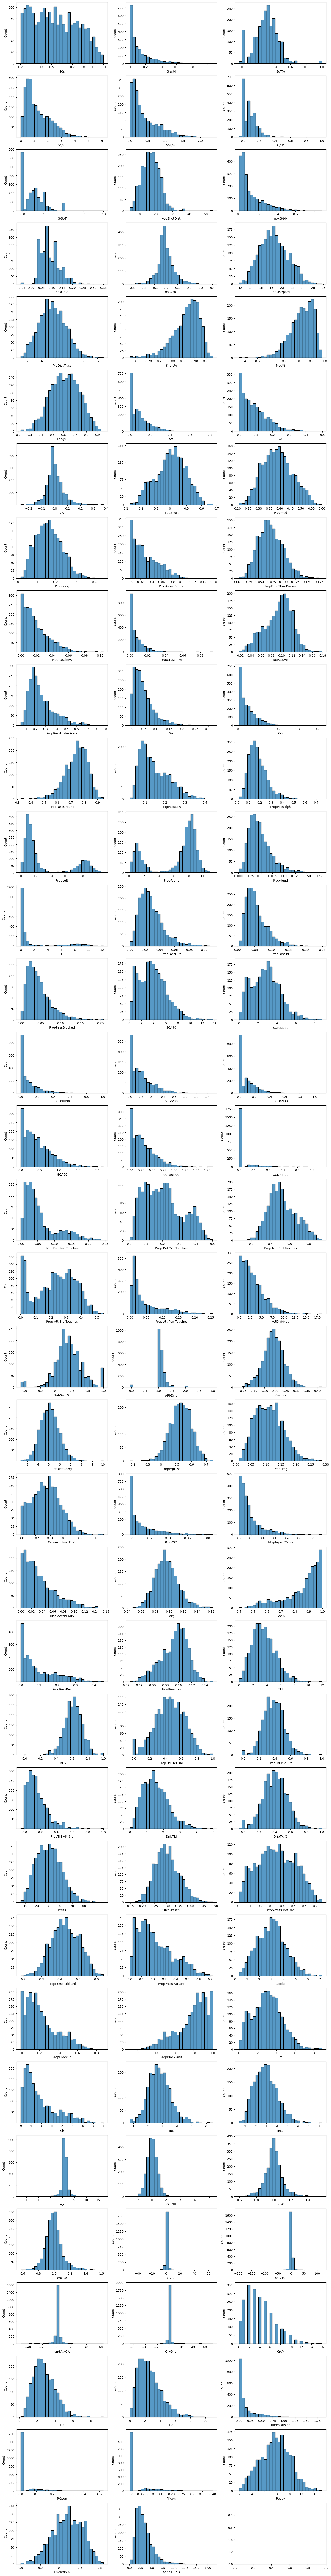

In [26]:
# Creating subplot axes

fig, axes = plt.subplots(35, 3, figsize=[18,150])

# Iterating through axes and names
for name, ax in zip(col_names, axes.flatten()):
    sns.histplot(x= name, data=plot_ind_df, bins = 30, ax=ax)
fig.savefig("../reports/normalized_data.png")

In [27]:
ind_df.iloc[:,95:104]

,onxG,onxGA,xG+/-,onG-xG,onGA-xGA,G-xG+/-,CrdY,Fls,Fld
1,1.089344,0.774668,3.538462,0.111554,1.193344,0.411111,10,4.063349,3.597650
2,0.984041,1.008562,1.053571,1.502825,0.991582,0.579365,4,2.863688,3.588517
5,1.012670,0.951823,-0.000000,-1.296928,1.152825,1.392857,1,0.845555,1.166302
6,0.949216,0.979490,1.100000,1.795732,0.926829,1.152174,4,2.146011,3.339495
9,0.936380,0.889296,1.013699,1.407920,0.507190,0.574766,2,1.542179,0.733295
...,...,...,...,...,...,...,...,...,...
3417,0.972897,1.014264,1.153846,2.207792,-5.621693,-34.000000,3,1.078749,1.472754
3419,1.094533,1.099314,1.000000,1.076826,2.513619,1.018868,3,2.211755,6.522142
3420,1.028770,1.000000,1.217391,1.745536,-0.000000,0.709677,7,1.907393,1.172241
3423,1.095055,1.039639,0.222222,1.194379,-0.154827,1.419355,6,1.347623,1.612192


In [28]:
# Before analyzing, going to delete columns that won't be used in clustering (namely, goal-creation and goal/assist data)
copy_ind_df = ind_df.copy()
copy_ind_df.drop(columns = ['Gls/90', 'G/Sh', 'G/SoT', 'np:G-xG', 'Ast',
          'xA', 'A-xA', 'GCA90', 'GCPass/90', 'GCDrib/90', 'DribSucc%', 'onG', 'onGA', '+/-',
           'On-Off', 'onxG', 'onxGA', 'xG+/-', 'onG-xG', 'onGA-xGA', 'G-xG+/-',  ], inplace=True)

/tmp/ipykernel_74613/1242139497.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = np.abs(copy_ind_df.corr())


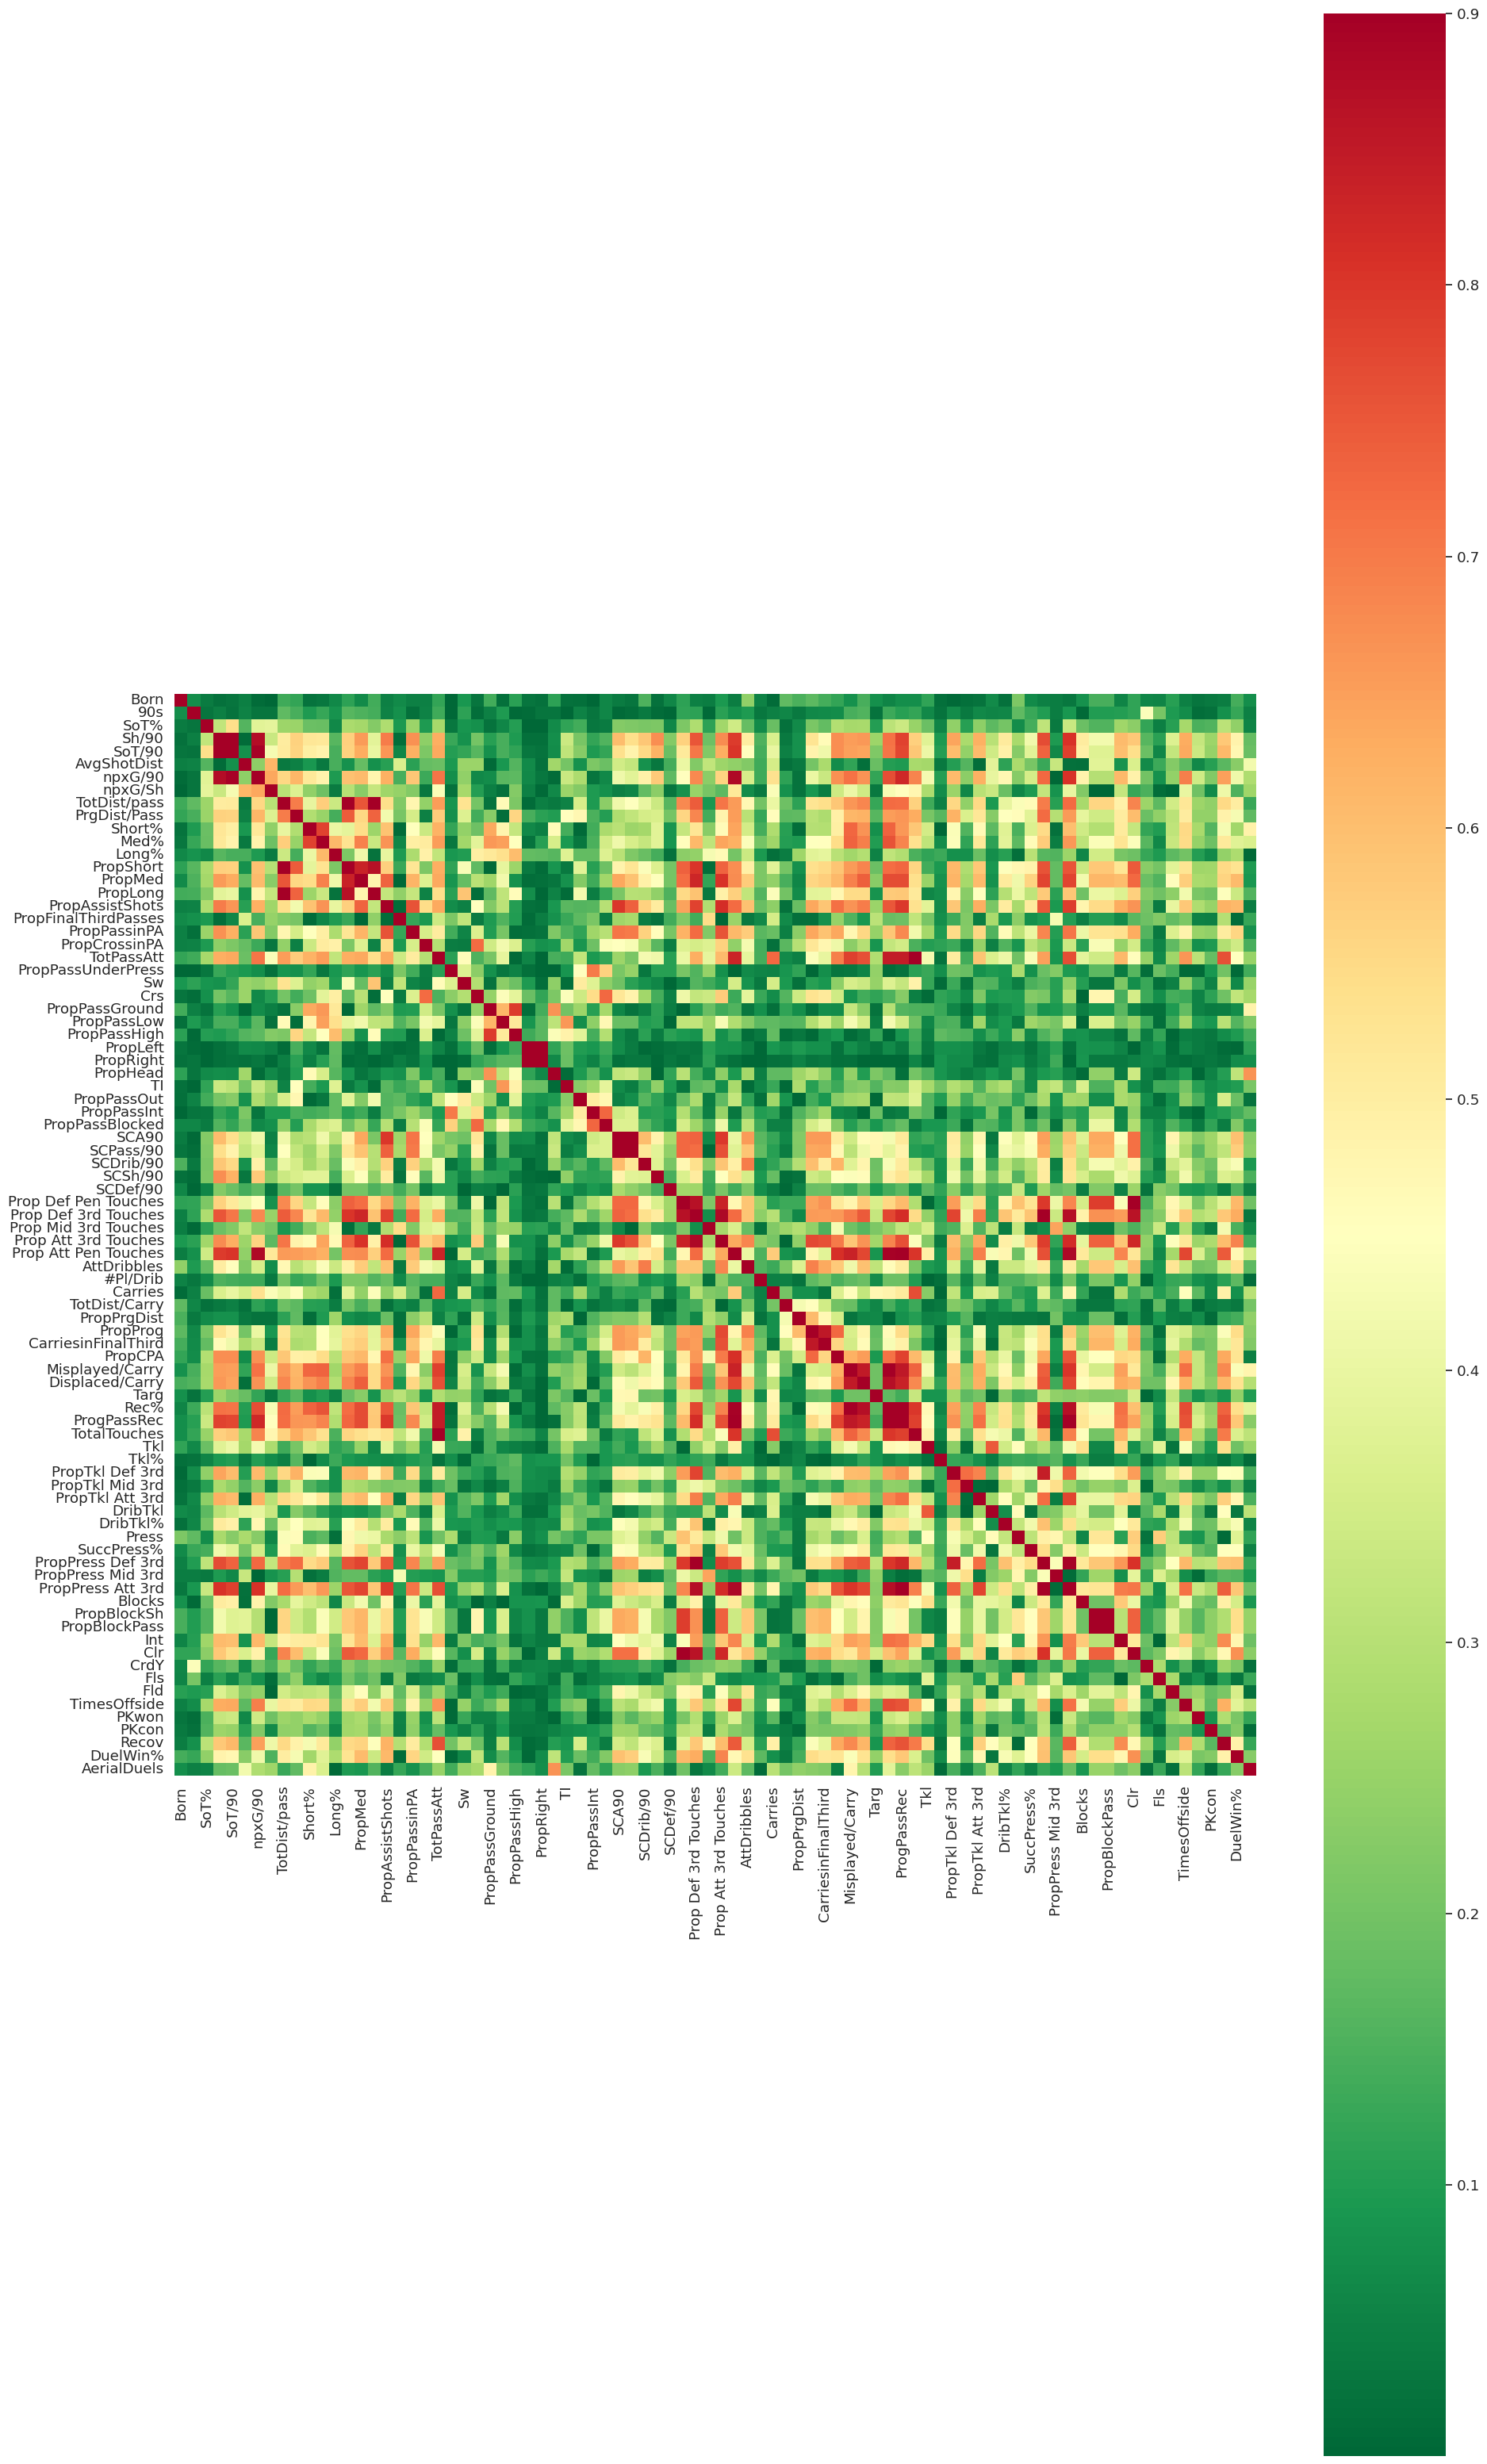

In [29]:
# Check for correlations too, I guess?
# Do them all (not super readable)
corrmat = np.abs(copy_ind_df.corr())
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(22,40))         # Sample figsize in inches
sns.heatmap(corrmat, vmax=0.9, square=True, cmap="RdYlGn_r")
plt.show()

/tmp/ipykernel_74613/2207941356.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = np.abs(ind_df.corr())


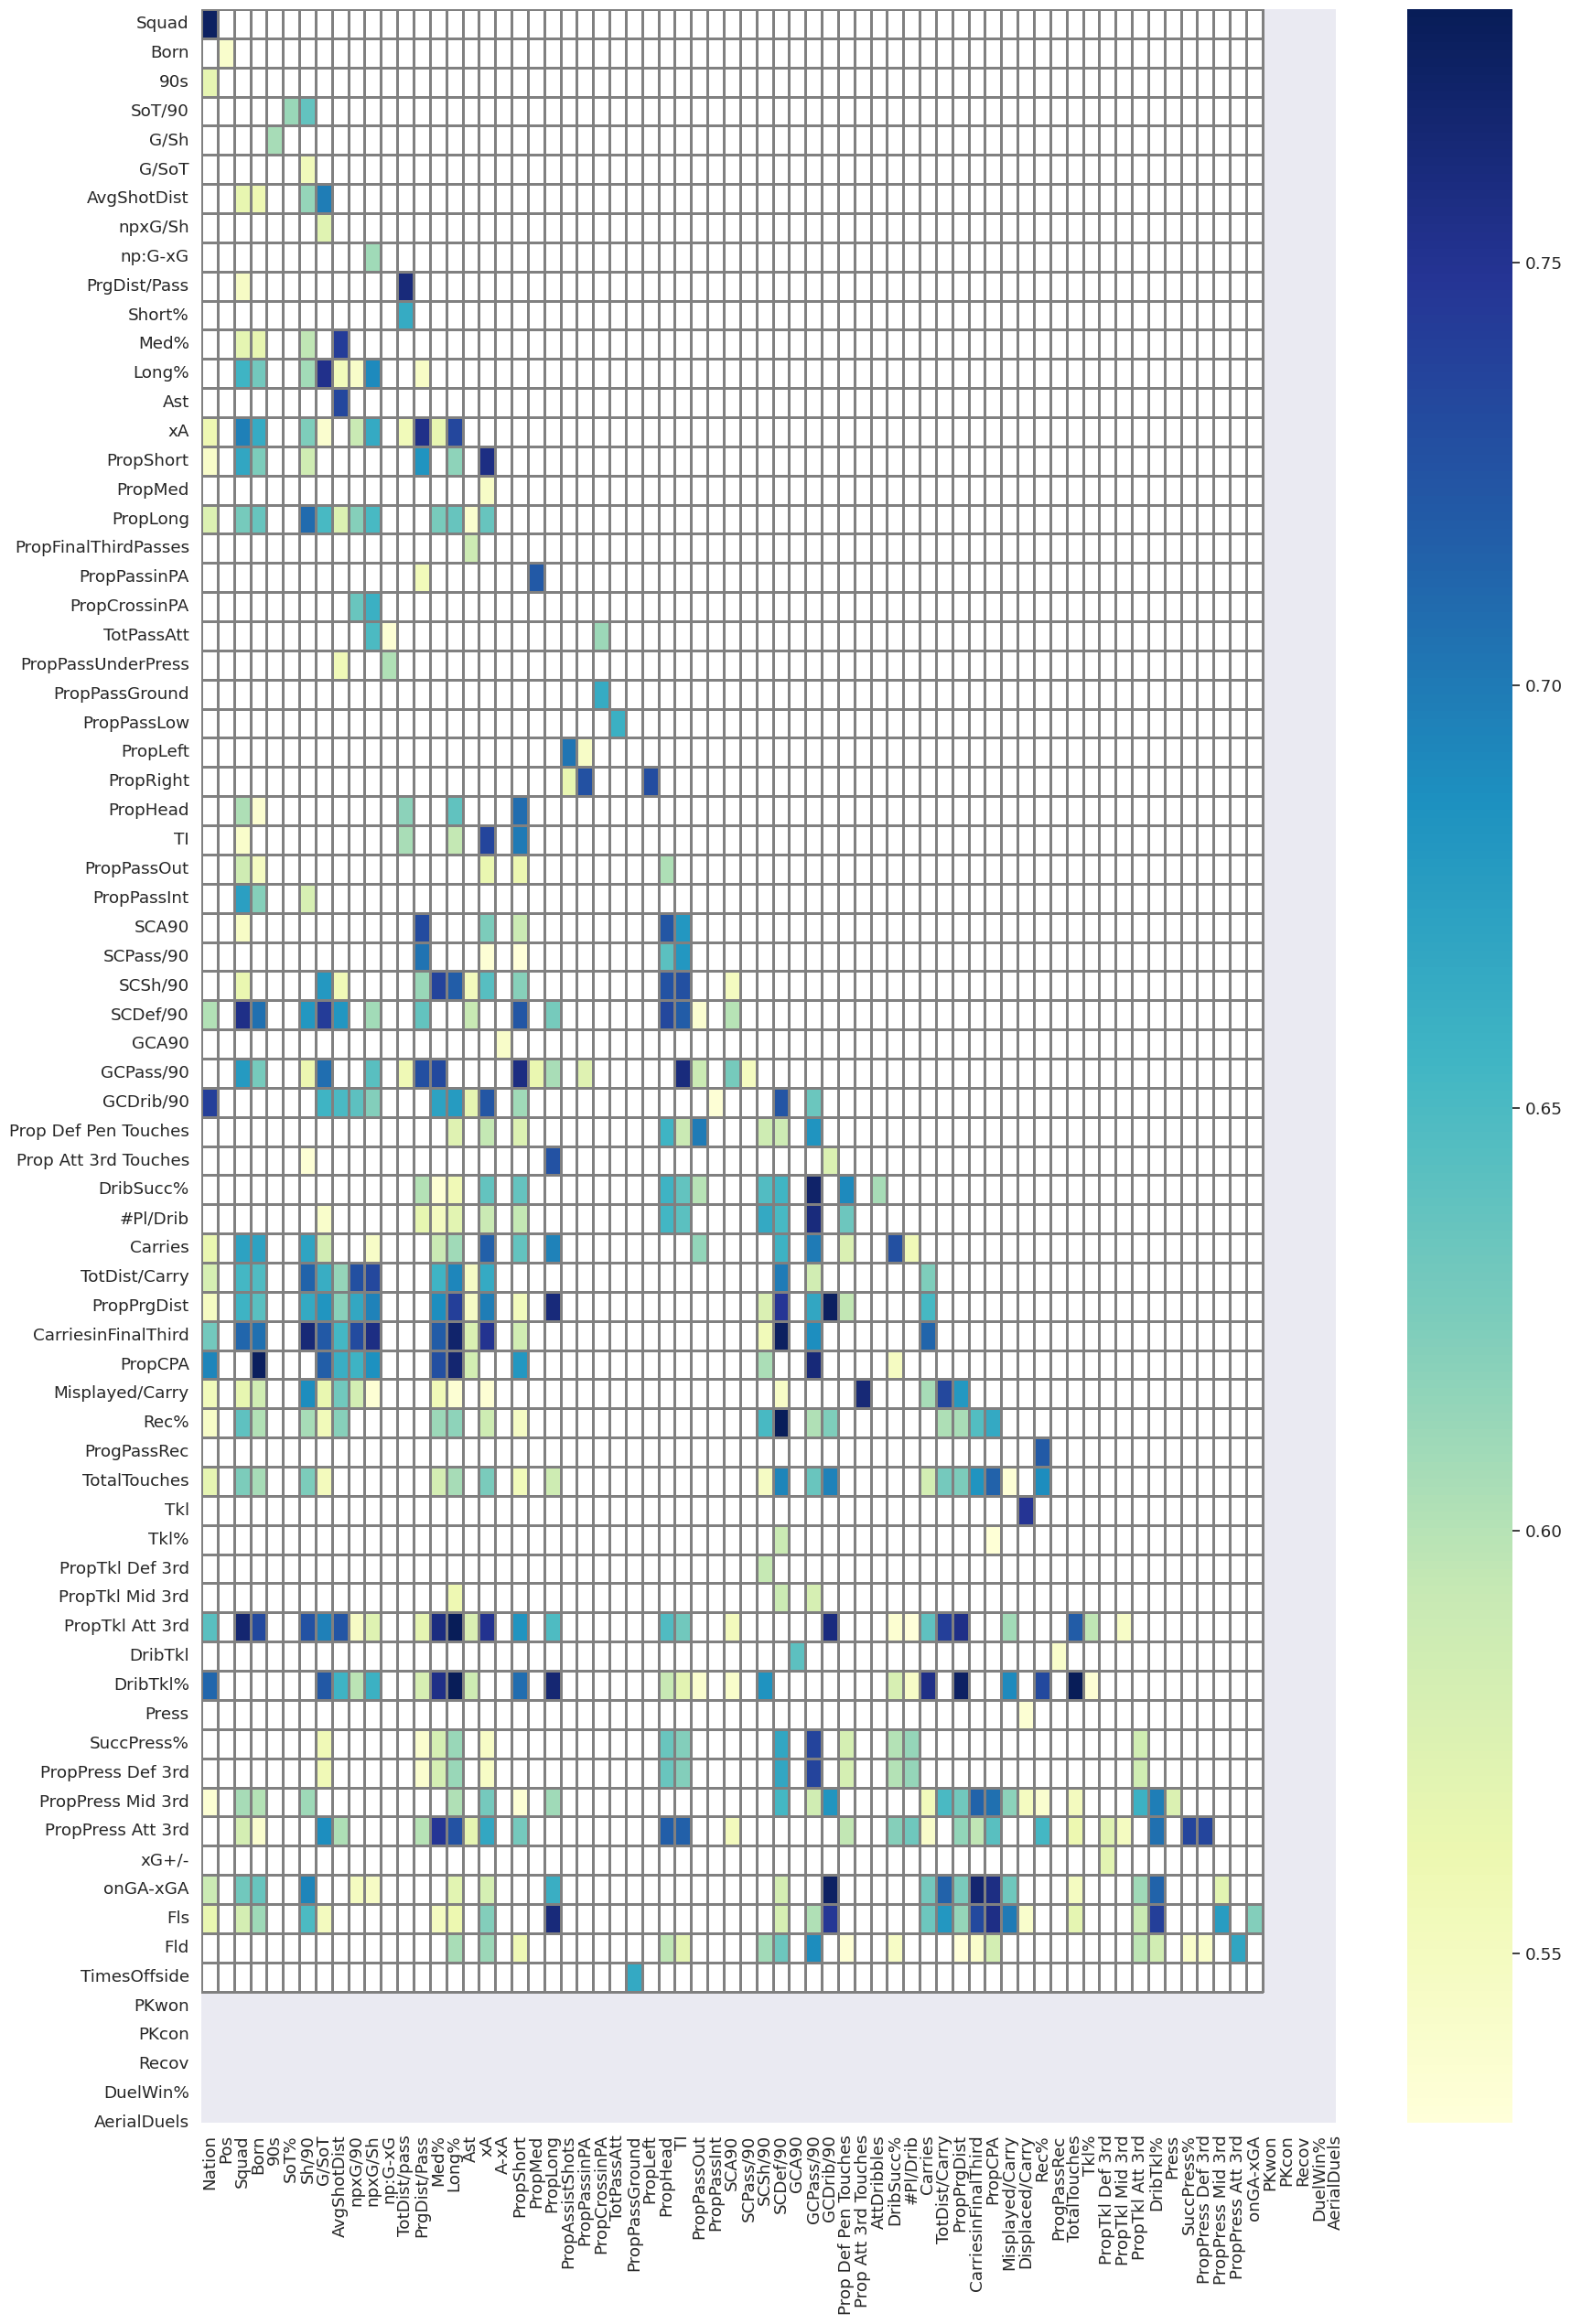

In [30]:
# Only check for correlations that are above certain threshold
from copy import copy
corr_thresh = 0.53
corr_max = 0.78

# Get names of things
labels = ind_df.columns

#plotting starts here
sns.set(font_scale=1.2)
#two axis objects just for comparison purposes
fig, ax = plt.subplots(figsize=(20,30))

#define the colormap with clipping values
my_cmap = copy(plt.cm.YlGnBu)
my_cmap.set_over("white")
my_cmap.set_under("white")

#remove empty rows/columns
# use only lower triangle

corrmat = np.abs(ind_df.corr())
corr = np.tril(corrmat)

#delete columns where all elements do not fulfill the conditions
ind_x,  = np.where(np.all(np.logical_or(corr<corr_thresh, corr>corr_max), axis=0))
corr = np.delete(corr, ind_x, 1)
#update x labels
map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    
#now the same for rows 
ind_y, = np.where(np.all(np.logical_or(corr<corr_thresh, corr>corr_max), axis=1))
corr = np.delete(corr, ind_y, 0)
#update y labels
map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

#plot heatmap
g2 = sns.heatmap(corr,
    xticklabels=map_labels_x,
    yticklabels=map_labels_y,
    vmin=corr_thresh,
    vmax=corr_max,
    cmap=my_cmap,
    linewidths=1.0,
    linecolor="grey", ax=ax)

# g2.set_title("Reduced heatmap")

plt.show()




General takeaways:

- Things that don't really correlate with anything: x-xA, Tkl% , PropRight/PropLeft (so footedness doesn't matter), SCDef, PropProgDist, 
- G-xG stats (G-xG, onG-onxG, onGA-onxGA), when normalized by team, begin to not matter very much 


Normalizing to do:
- Standard Scaler (rescale values so mean=0, variance=1)
    - 'TotDist/pass', 'PrgDist/Pass', 'Att', 'TotDist/Carry', 'Targ', 'Def 3rd Touch', 'Tkl', 'DribTkl', 
       'Press', 'Blocks', 'Int', 'Clr', 'Fls', 'Fld', 'Recov', 'AerialDuels'
- Min-Max Scaler (scale to be between 0-1)
         - 'TI'
- Robust Scaler (for outliers)
         - Dist


In [31]:
# Remove the stats that we've seen from EDA may not be relevant (low correlations, accounted for by other stats...)
ind_df.drop(columns=["SoT%", "SoT/90", 'G/Sh', 'G/SoT', 'Tkl%', 'SCDef/90', 'SCA90', 'GCA90', 'PropPrgDist', 'CrdY', 'PKwon', 'PKcon'], inplace=True)

In [32]:
team_df.to_csv(f'../data/processed/sb_team.csv') #Assumes location of 'data' folder
ind_df.to_csv(f'../data/processed/sb_individual.csv') #Assumes location of 'data' folder